In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from dateutil import parser

In [4]:
# Load the data
file_path = 'ny_taxi_data.csv'
data = pd.read_csv(file_path)
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id1019488,2,1/1/2016 0:08,1/1/2016 0:22,1,-73.976120,40.749081,-74.007446,40.726452,N
1,id2336715,2,1/1/2016 0:09,1/1/2016 0:19,2,-73.984360,40.748985,-73.996284,40.716057,N
2,id3150178,2,1/1/2016 0:18,1/1/2016 0:34,1,-73.974968,40.777721,-73.973885,40.757427,N
3,id3393823,2,1/1/2016 0:30,1/1/2016 0:51,1,-73.990868,40.745167,-73.977638,40.784027,N
4,id1349085,2,1/1/2016 0:33,1/1/2016 0:50,1,-74.007980,40.740208,-73.988922,40.765083,N


In [5]:
# Function to parse mixed datetime formats
def parse_date(date_str):
    return parser.parse(date_str)

# Apply the function to datetime columns
data['pickup_datetime'] = data['pickup_datetime'].apply(parse_date)
data['dropoff_datetime'] = data['dropoff_datetime'].apply(parse_date)

# Calculate trip duration in minutes
data['trip_duration'] = (data['dropoff_datetime'] - data['pickup_datetime']).dt.total_seconds() / 60.0

# Extract features from datetime
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_day'] = data['pickup_datetime'].dt.dayofweek

# Encode the 'store_and_fwd_flag'
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

# Drop unnecessary columns
data.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime'], inplace=True)

In [6]:
data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day
0,2,1,-73.976120,40.749081,-74.007446,40.726452,0,14.0,0,4
1,2,2,-73.984360,40.748985,-73.996284,40.716057,0,10.0,0,4
2,2,1,-73.974968,40.777721,-73.973885,40.757427,0,16.0,0,4
3,2,1,-73.990868,40.745167,-73.977638,40.784027,0,21.0,0,4
4,2,1,-74.007980,40.740208,-73.988922,40.765083,0,17.0,0,4


In [27]:
from sklearn.preprocessing import MinMaxScaler

# Prepare the sequence data
def create_sequences(data, sequence_length=10):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length+1])
    return np.array(sequences)

# Extract passenger_count column
passenger_counts = data['passenger_count'].values
scaler = MinMaxScaler()
passenger_counts_1 = scaler.fit_transform(passenger_counts.reshape(-1, 1))

# Create sequences
sequence_length = 10  # You can adjust this value
sequences = create_sequences(passenger_counts_1, sequence_length)

# Split sequences into features and target
X = sequences[:, :-1]
y = sequences[:, -1]

# Reshape X for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Reshape data to 3D for LSTM [samples, timesteps, features]
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [30]:
# Define the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 50)             12200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32451 (126.76 KB)
Trainable params: 32451 (126.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
322/322 [==============================] - 13s 13ms/step - loss: 0.0713 - val_loss: 0.0669
Epoch 2/20
322/322 [==============================] - 4s 11ms/step - loss: 0.0704 - val_loss: 0.0667
Epoch 3/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0704 - val_loss: 0.0666
Epoch 4/20
322/322 [==============================] - 4s 13ms/step - loss: 0.0705 - val_loss: 0.0667
Epoch 5/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0704 - val_loss: 0.0667
Epoch 6/20
322/322 [==============================] - 4s 11ms/step - loss: 0.0705 - val_loss: 0.0666
Epoch 7/20
322/322 [==============================] - 4s 14ms/step - loss: 0.0704 - val_loss: 0.0666
Epoch 8/20
322/322 [==============================] - 3s 11ms/step - loss: 0.0704 - val_loss: 0.0667
Epoch 9/20
322/322 [==============================] - 4s 11ms/step - loss: 0.0704 - val_loss: 0.0668
Epoch 10/20
322/322 [==============================] - 4s 13ms/step - loss: 0.0703 - val_l

In [32]:
# Evaluate the model on the test data
y_pred = model.predict(X_test_reshaped)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f'RMSE: {rmse}')

101/101 [==============================] - 2s 4ms/step
RMSE: 0.2637559453837606


In [33]:
y_pred_new = np.round(y_pred)

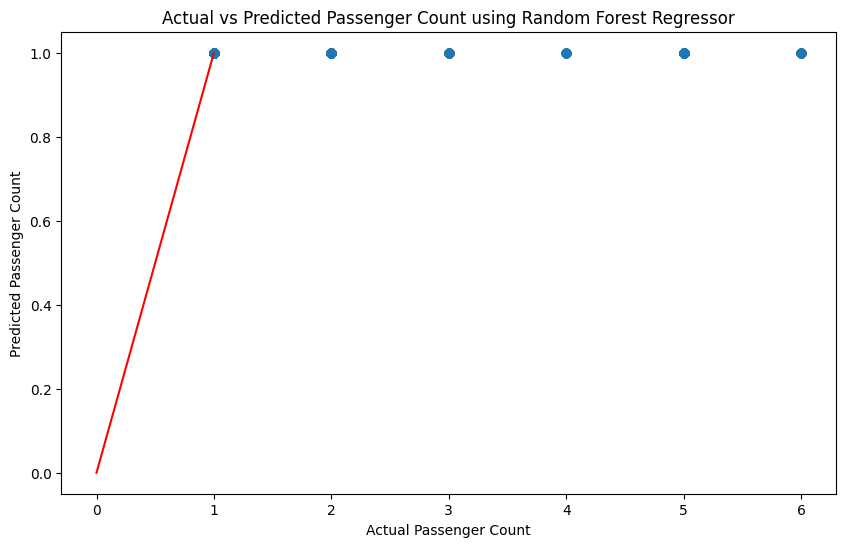

In [38]:
import matplotlib.pyplot as plt

# Assuming the Random Forest Regressor model is already trained and y_pred contains the predictions

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_new, alpha=0.5)
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.title('Actual vs Predicted Passenger Count using Random Forest Regressor')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()


In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_new)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest Regressor')
plt.show()

ValueError: Classification metrics can't handle a mix of continuous and binary targets